<a href="https://colab.research.google.com/github/lpgod/resnet/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc



def get_metrics(true_labels, predicted_labels):

    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels,
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))


def train_predict_model(classifier,
                        train_features, train_labels,
                        test_features, test_labels):
    # build model
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features)
    return predictions


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):

    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels,
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm,
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes],
                                                  labels=level_labels),
                            index=pd.MultiIndex(levels=[['Actual:'], classes],
                                                labels=level_labels))
    print(cm_frame)

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels,
                                           y_pred=predicted_labels,
                                           labels=classes)
    print(report)



def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels,
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels,
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):

    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")

    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)

    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black',
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):

    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1]
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)

    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]),
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600
from keras.applications import ResNet50

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

## Load and Prepare DataSet

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 3s 0us/step


Split training dataset in train and validation sets



In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

Transform target variable/labels into one hot encoded form

In [ ]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

### Preprocessing

Since we are about to use resnet as a feature extractor, the minimum size of an image it takes is 32x32.
We utilize ```scipy`` to resize images to required dimensions

In [ ]:
X_train = np.array([x.reshape((32 , 32,3)) for x in X_train])
X_val = np.array([x.reshape((32 , 32,3)) for x in X_val])
X_test = np.array([x.reshape((32 , 32,3)) for x in X_test])

## Prepare the Model

* Load resnet50 without the top classification layer
* Prepare a custom classifier
* Stack both models on top of each other

In [ ]:
base_model = ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(32, 32,3))

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
last = base_model.get_layer('conv5_block1_1_conv').output
low = base_model.get_layer('conv2_block1_2_conv').output
mid = base_model.get_layer('conv3_block1_1_conv').output
high = base_model.get_layer('conv4_block2_1_conv').output

In [ ]:
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model =tf.keras.Model(base_model.input, pred)

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [ ]:
x = GlobalAveragePooling2D()(low)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model_low =tf.keras.Model(base_model.input, pred)

In [ ]:
x = GlobalAveragePooling2D()(mid)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model_mid =tf.keras.Model(base_model.input, pred)

In [ ]:
x = GlobalAveragePooling2D()(high)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model_high =tf.keras.Model(base_model.input, pred)

In [ ]:
model_low.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [ ]:
model_mid.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [ ]:
model_high.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

## Data Augmentation

To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using
```keras ``` utilities

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [ ]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

## Train the Model

In [ ]:
#whole model train
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/10
1328/1328 [==============================] - 28s 14ms/step - loss: 0.3224 - accuracy: 0.2676 - val_loss: 0.2566 - val_accuracy: 0.4251
Epoch 2/10
1328/1328 [==============================] - 18s 13ms/step - loss: 0.2712 - accuracy: 0.3721 - val_loss: 0.2412 - val_accuracy: 0.4498
Epoch 3/10
1328/1328 [==============================] - 18s 13ms/step - loss: 0.2567 - accuracy: 0.4135 - val_loss: 0.2337 - val_accuracy: 0.4677
Epoch 4/10
1328/1328 [==============================] - 17s 13ms/step - loss: 0.2471 - accuracy: 0.4372 - val_loss: 0.2276 - val_accuracy: 0.4824
Epoch 5/10
1328/1328 [==============================] - 18s 13ms/step - loss: 0.2411 - accuracy: 0.4549 - val_loss: 0.2223 - val_accuracy: 0.4993
Epoch 6/10
1328/1328 [==============================] - 17s 13ms/step - loss: 0.2355 - accuracy: 0.4672 - val_loss: 0.2181 - val_accuracy: 0.5077
Epoch 7/10
1328/1328 [==============================] - 17s 13ms/step - loss: 0.2312 - accuracy: 0.4807 - val_loss: 0.2151 -

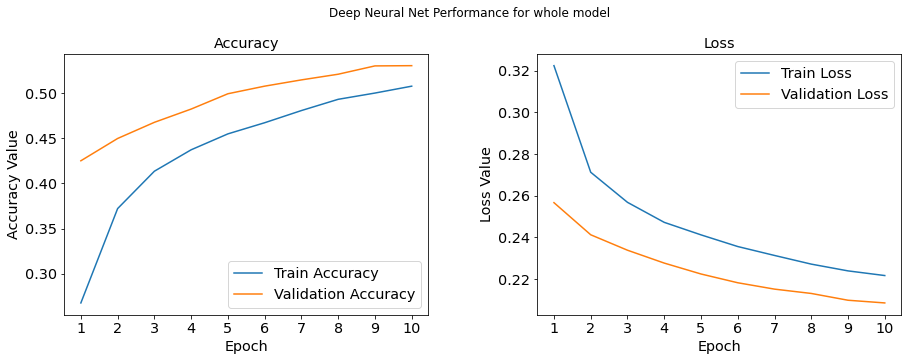

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance for whole model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
predictions = model.predict(X_test/255.)


313/313 [==============================] - 3s 8ms/step


In [ ]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [ ]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.5312
Precision: 0.5261
Recall: 0.5312
F1 Score: 0.5266


In [ ]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [ ]:

def make_prediction(model=None,img_vector=[],
                    label_dict={},top_N=3,
                    model_input_shape=None):
    if model:
        if not model_input_shape:
            model_input_shape = (1,)+model.get_input_shape_at(0)[1:]

        prediction = model.predict(img_vector.reshape(model_input_shape))[0]


        labels_predicted = [label_dict[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
        confidence_predicted = np.sort(prediction)[::-1][:top_N]

        return labels_predicted, confidence_predicted

In [ ]:
def plot_predictions(model,dataset,
                    dataset_labels,label_dict,
                    batch_size,grid_height,grid_width):
    if model:
        f, ax = plt.subplots(grid_width, grid_height)
        f.set_size_inches(12, 12)

        random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

        img_idx = 0
        for i in range(0, grid_width):
            for j in range(0, grid_height):
                actual_label = label_dict.get(dataset_labels[random_batch_indx[img_idx]].argmax())
                preds,confs_ = make_prediction(model,
                                              img_vector=dataset[random_batch_indx[img_idx]],
                                              label_dict=label_dict,
                                              top_N=1)
                ax[i][j].axis('off')
                ax[i][j].set_title('Actual:'+actual_label[:10]+\
                                    '\nPredicted:'+preds[0] + \
                                    '(' +str(round(confs_[0],2)) + ')')
                ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
                img_idx += 1

        plt.subplots_adjust(left=0, bottom=0, right=1,
                            top=1, wspace=0.4, hspace=0.55)



1/1 [==============================] - 0s 19ms/step


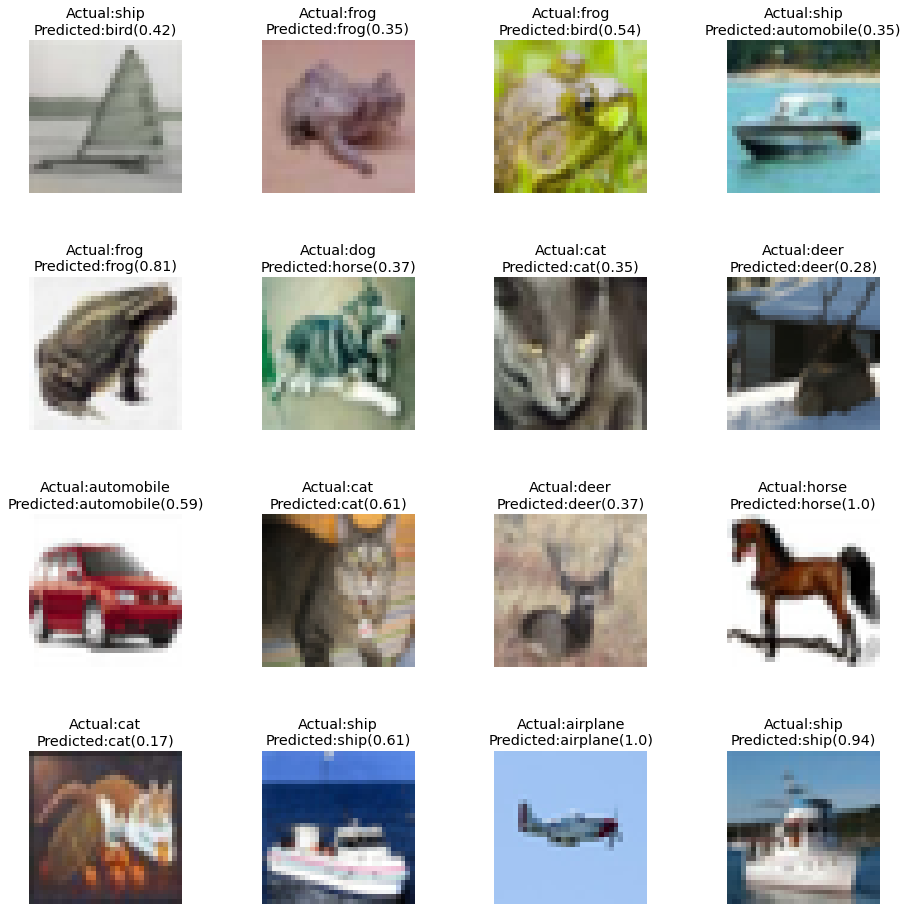

In [ ]:
#whole model prediction result
model(tf.keras.Input((32, 32, 3)))

plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)

In [ ]:
#low level train

train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model_low.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/10
1328/1328 [==============================] - 9s 6ms/step - loss: 0.3334 - accuracy: 0.2337 - val_loss: 0.2656 - val_accuracy: 0.3678
Epoch 2/10
1328/1328 [==============================] - 9s 6ms/step - loss: 0.2707 - accuracy: 0.3434 - val_loss: 0.2515 - val_accuracy: 0.4052
Epoch 3/10
1328/1328 [==============================] - 8s 6ms/step - loss: 0.2605 - accuracy: 0.3775 - val_loss: 0.2452 - val_accuracy: 0.4233
Epoch 4/10
1328/1328 [==============================] - 8s 6ms/step - loss: 0.2546 - accuracy: 0.3973 - val_loss: 0.2405 - val_accuracy: 0.4323
Epoch 5/10
1328/1328 [==============================] - 8s 6ms/step - loss: 0.2500 - accuracy: 0.4086 - val_loss: 0.2368 - val_accuracy: 0.4435
Epoch 6/10
1328/1328 [==============================] - 8s 6ms/step - loss: 0.2460 - accuracy: 0.4210 - val_loss: 0.2337 - val_accuracy: 0.4511
Epoch 7/10
1328/1328 [==============================] - 8s 6ms/step - loss: 0.2433 - accuracy: 0.4292 - val_loss: 0.2311 - val_accuracy:

In [ ]:
predictions = model_low.predict(X_test/255.)

313/313 [==============================] - 1s 2ms/step


In [ ]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [ ]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.4756
Precision: 0.4631
Recall: 0.4756
F1 Score: 0.4609


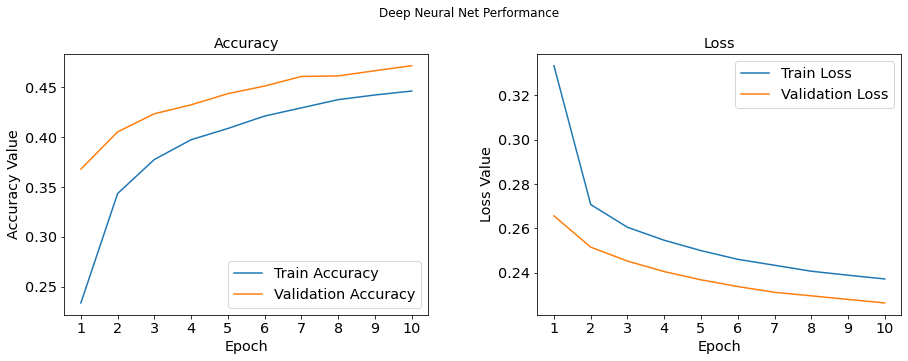

In [ ]:
#low level plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

1/1 [==============================] - 0s 21ms/step


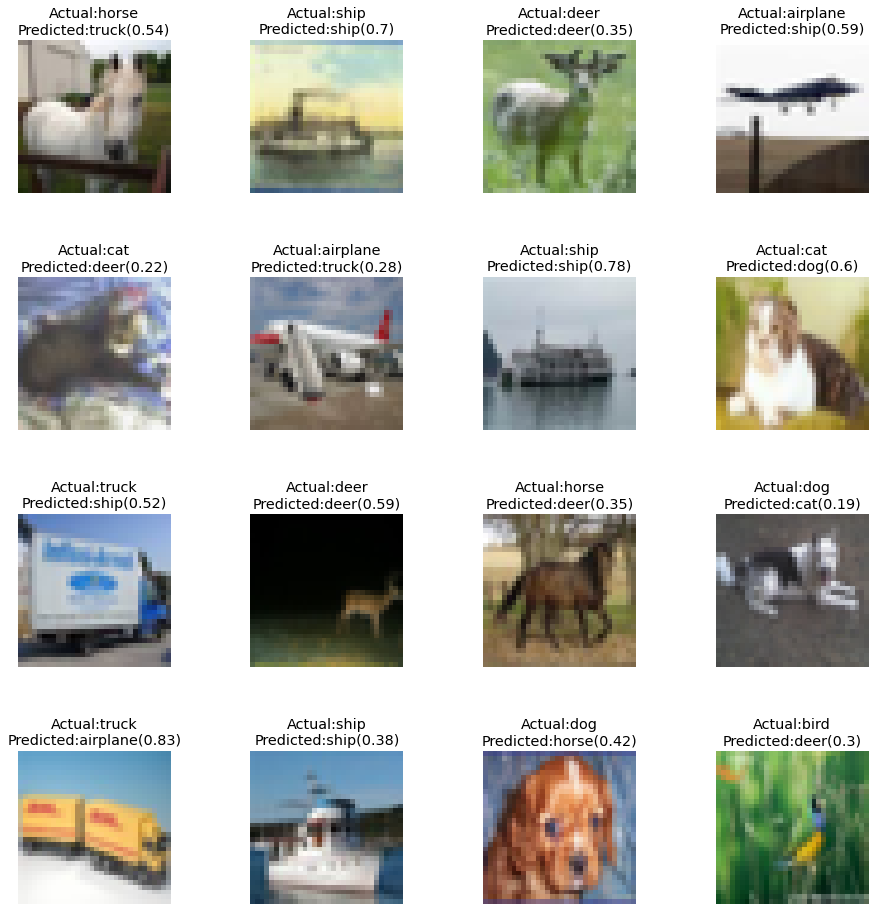

In [ ]:
#love level prediction result
model_low(tf.keras.Input((32, 32, 3)))

plot_predictions(model=model_low,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)

In [ ]:

#mid level train
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model_mid.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/10
1328/1328 [==============================] - 11s 8ms/step - loss: 0.3221 - accuracy: 0.2662 - val_loss: 0.2608 - val_accuracy: 0.3973
Epoch 2/10
1328/1328 [==============================] - 10s 7ms/step - loss: 0.2701 - accuracy: 0.3679 - val_loss: 0.2442 - val_accuracy: 0.4435
Epoch 3/10
1328/1328 [==============================] - 10s 7ms/step - loss: 0.2537 - accuracy: 0.4130 - val_loss: 0.2331 - val_accuracy: 0.4724
Epoch 4/10
1328/1328 [==============================] - 9s 7ms/step - loss: 0.2442 - accuracy: 0.4429 - val_loss: 0.2266 - val_accuracy: 0.4857
Epoch 5/10
1328/1328 [==============================] - 10s 8ms/step - loss: 0.2373 - accuracy: 0.4623 - val_loss: 0.2223 - val_accuracy: 0.5009
Epoch 6/10
1328/1328 [==============================] - 10s 7ms/step - loss: 0.2332 - accuracy: 0.4731 - val_loss: 0.2189 - val_accuracy: 0.5114
Epoch 7/10
1328/1328 [==============================] - 10s 7ms/step - loss: 0.2294 - accuracy: 0.4810 - val_loss: 0.2165 - val_acc

In [ ]:
predictions = model_mid.predict(X_test/255.)

313/313 [==============================] - 1s 3ms/step


In [ ]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [ ]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.5223
Precision: 0.5165
Recall: 0.5223
F1 Score: 0.5141


1/1 [==============================] - 0s 17ms/step


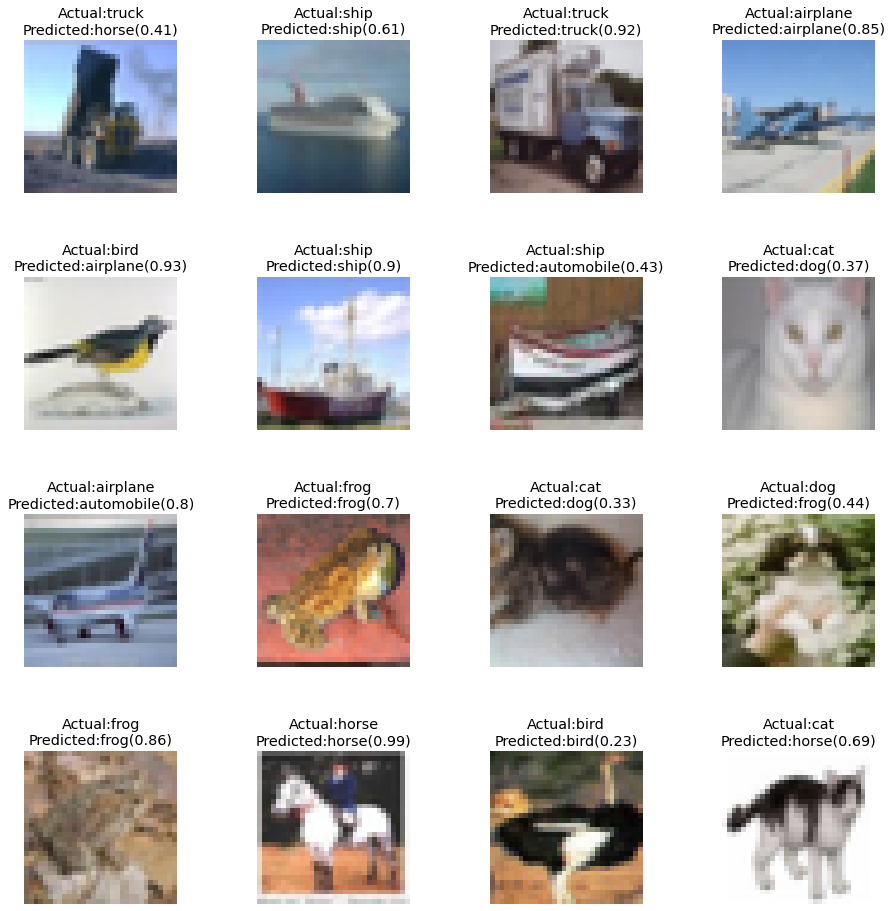

In [ ]:
#love level prediction result
model_mid(tf.keras.Input((32, 32, 3)))

plot_predictions(model=model_mid,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)

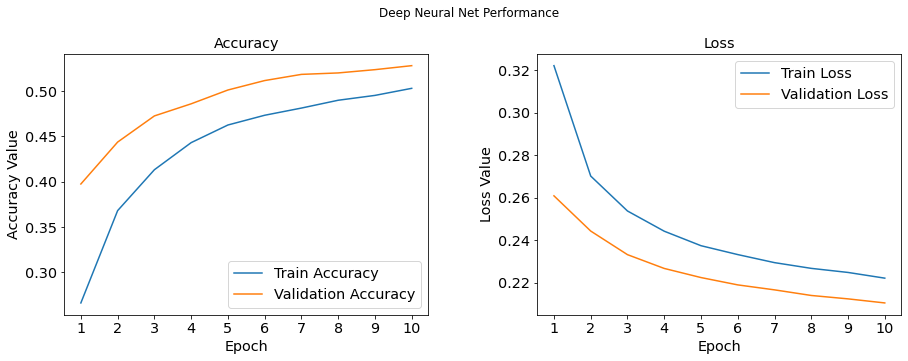

In [ ]:
#mid level plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#high level train
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model_high.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/10
1328/1328 [==============================] - 15s 10ms/step - loss: 0.3189 - accuracy: 0.2699 - val_loss: 0.2522 - val_accuracy: 0.4326
Epoch 2/10
1328/1328 [==============================] - 13s 10ms/step - loss: 0.2653 - accuracy: 0.3903 - val_loss: 0.2355 - val_accuracy: 0.4746
Epoch 3/10
1328/1328 [==============================] - 14s 10ms/step - loss: 0.2500 - accuracy: 0.4298 - val_loss: 0.2264 - val_accuracy: 0.4916
Epoch 4/10
1328/1328 [==============================] - 14s 10ms/step - loss: 0.2400 - accuracy: 0.4557 - val_loss: 0.2208 - val_accuracy: 0.5076
Epoch 5/10
1328/1328 [==============================] - 13s 10ms/step - loss: 0.2334 - accuracy: 0.4751 - val_loss: 0.2149 - val_accuracy: 0.5186
Epoch 6/10
1328/1328 [==============================] - 13s 10ms/step - loss: 0.2278 - accuracy: 0.4853 - val_loss: 0.2115 - val_accuracy: 0.5271
Epoch 7/10
1328/1328 [==============================] - 14s 10ms/step - loss: 0.2236 - accuracy: 0.5007 - val_loss: 0.2081 -

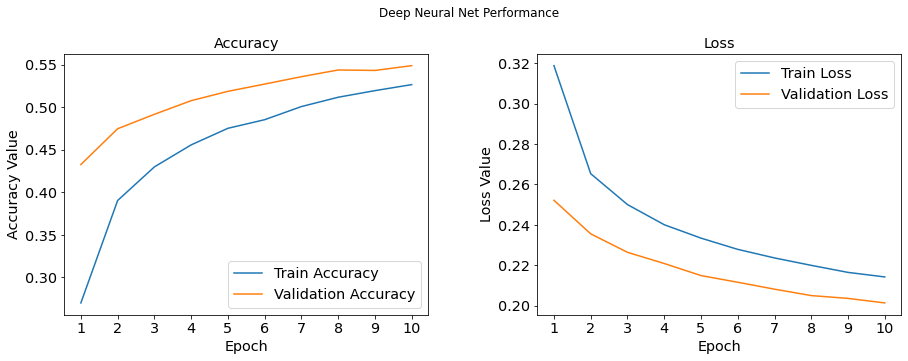

In [ ]:
#high level plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
predictions = model_high.predict(X_test/255.)

313/313 [==============================] - 2s 5ms/step


In [ ]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [ ]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.5514
Precision: 0.5442
Recall: 0.5514
F1 Score: 0.5437


1/1 [==============================] - 0s 19ms/step


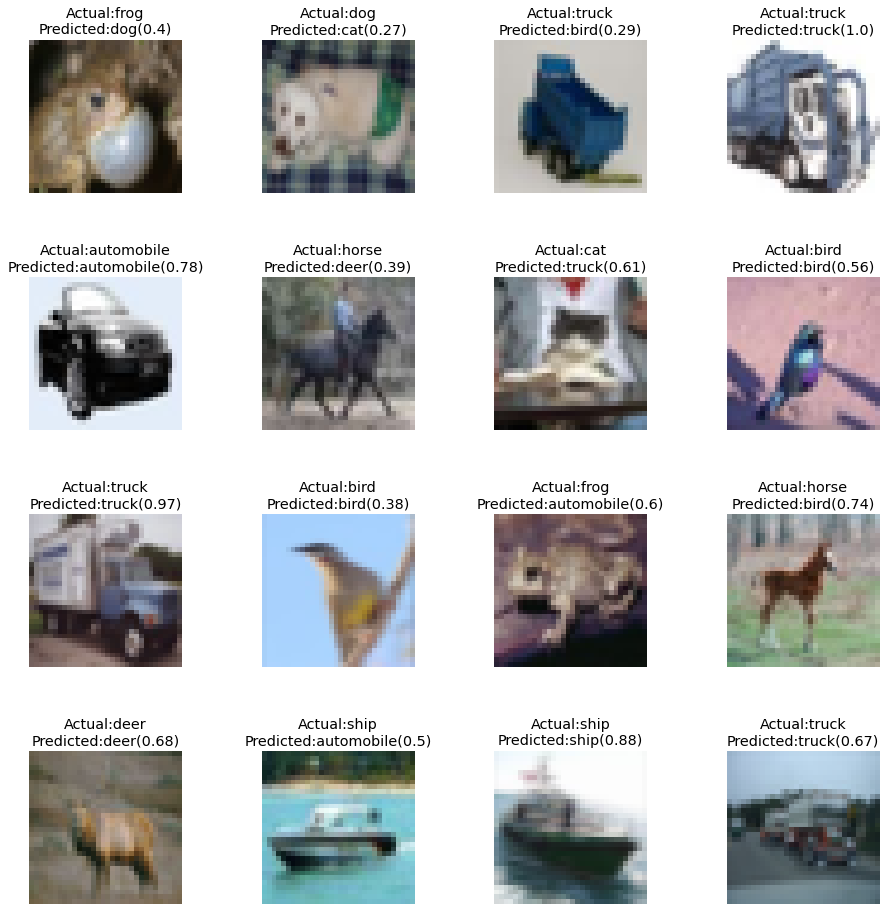

In [ ]:
#high level prediction result
model_high(tf.keras.Input((32, 32, 3)))

plot_predictions(model=model_high,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)